<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook_2021/Lab05_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
path0 = '/content/drive/MyDrive/data/brats18/brats18_train' # replace your data path
dpiv = 80

## Load Nifti Image and Apply Transform (MONAI)
- https://github.com/Project-MONAI/tutorials


In [3]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [4]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

In [5]:
train_ind = np.arange(0,10)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [6]:
train_files[:4]

[{'image': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AQD_1/t1ce.nii.gz',
  'label': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AQD_1/seg.nii.gz'},
 {'image': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_ASA_1/t1ce.nii.gz',
  'label': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_ASA_1/seg.nii.gz'},
 {'image': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AAB_1/t1ce.nii.gz',
  'label': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AAB_1/seg.nii.gz'},
 {'image': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_APR_1/t1ce.nii.gz',
  'label': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_APR_1/seg.nii.gz'}]

In [7]:
loader = LoadImaged(keys=("image","label"))

image shape: (240, 240, 155)
label shape: (240, 240, 155)


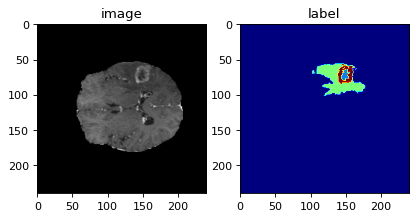

In [8]:
data_dict = loader(train_files[0])
image, label = data_dict["image"], data_dict["label"]
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")

plt.figure(dpi=dpiv)
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 72], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 72], cmap='jet')
plt.show()

In [9]:
add_channel = AddChanneld(keys=["image", "label"])
datac_dict = add_channel(data_dict)
print(f"image shape: {datac_dict['image'].shape}")

image shape: (1, 240, 240, 155)


In [10]:
rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    spatial_size=(192, 192, 128),
    translate_range=(16, 16, 4),
    rotate_range=(np.pi * (30/180), np.pi * (30/180), np.pi * (30/180)),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)

image shape: (1, 192, 192, 128)


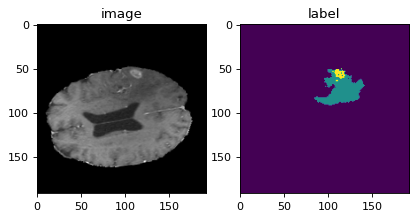

In [11]:
affined_data_dict = rand_affine(datac_dict)
print(f"image shape: {affined_data_dict['image'].shape}")

image, label = affined_data_dict["image"][0], affined_data_dict["label"][0]
plt.figure(dpi=dpiv)
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 72], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 72])
plt.show()

## Image Segmentation

In [12]:
import scipy.signal as signal
import scipy.ndimage as nd

In [13]:
data_dict = loader(train_files[-1])
image, label = data_dict["image"], data_dict["label"]

In [14]:
data_dict['image_meta_dict']

{'affine': array([[ -1.,   0.,   0.,  -0.],
        [  0.,  -1.,   0., 239.],
        [  0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   1.]]),
 'as_closest_canonical': False,
 'bitpix': array(16, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'datatype': array(4, dtype=int16),
 'dim': array([  3, 240, 240, 155,   1,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'filename_or_obj': '/content/drive/MyDrive/data/brats18/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz',
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'original_affine': array([[ -1.,   0.,   0.,  -0.],
        [  0.,  -1.,   0., 239.],
        [  0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   1.]]),
 'original_channel_dim': 'no_channel',
 'pix

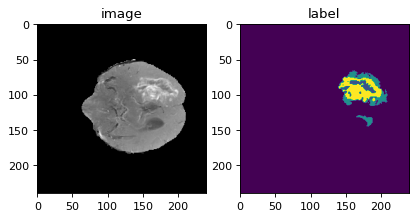

(208, 208)


In [15]:
z = 58
plt.figure(dpi=dpiv)
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, z], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, z])
plt.show()

I = np.transpose(image[16:-16,16:-16,z],(1,0))
print(I.shape)

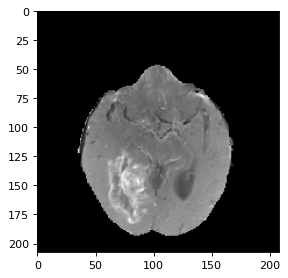

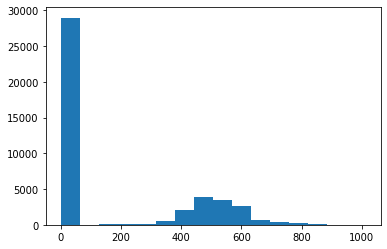

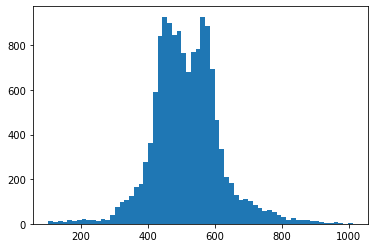

In [16]:
plt.figure(dpi=dpiv)
plt.imshow(I, cmap = 'gray')
plt.show()
plt.hist(I.ravel(),16)
plt.show()
plt.hist(I[I>100].ravel(),64)
plt.show()

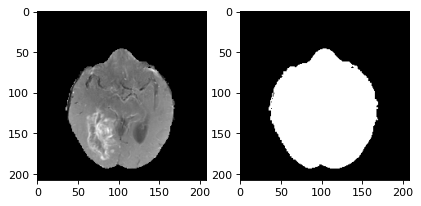

In [17]:
th = 100
Ith = np.zeros(I.shape)
Ith[I>th] = 1

plt.figure(dpi=dpiv)
plt.subplot(121)
plt.imshow(I,cmap='gray')
plt.subplot(122)
plt.imshow(Ith, cmap = 'gray')
plt.show()

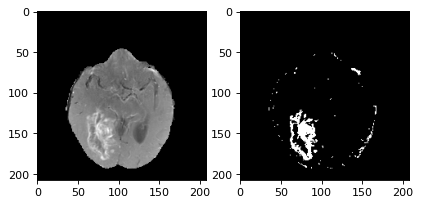

In [18]:
th = 640
Ith = np.zeros(I.shape)
Ith[I>th] = 1
plt.figure(dpi=dpiv)
plt.subplot(121)
plt.imshow(I,cmap='gray')
plt.subplot(122)
plt.imshow(Ith, cmap = 'gray')
plt.show()

### Smoothing before thresholding

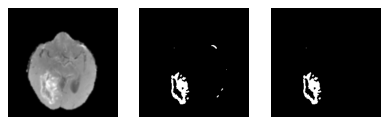

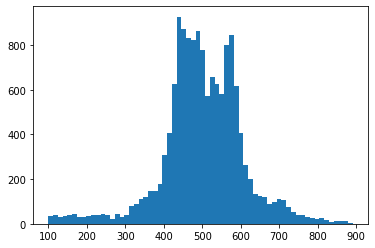

In [19]:
th = 640
Is = nd.gaussian_filter(I,1)
Isth = np.zeros(I.shape)
Isth[Is>th]=1   
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(Is,cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(Isth, cmap = 'gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(Isth*nd.binary_erosion(I>100,np.ones((9,9))), cmap = 'gray')
plt.axis('off')
plt.show()

plt.hist(Is[Is>100].ravel(),64)
plt.show()

### Calculate the area of the enhanced region

In [20]:
I_enhanced = Isth*nd.binary_erosion(I>100,np.ones((9,9)))
num_enhanced = np.sum(I_enhanced>0)
print(data_dict['image_meta_dict']['pixdim'][:2])
area_enhanced = np.prod(data_dict['image_meta_dict']['pixdim'][:2]) * num_enhanced
print(f'area: {area_enhanced} mm^2')

[1. 1.]
area: 1010.0 mm^2


### Using Edges

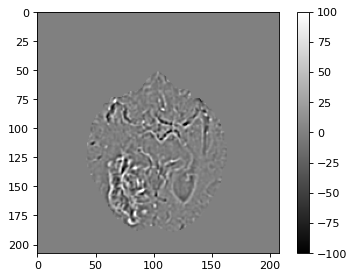

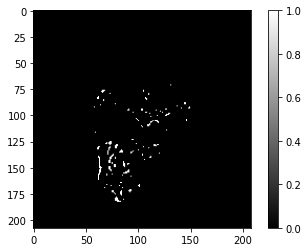

In [21]:
th = 640
Ih = nd.laplace(nd.gaussian_filter(I,1))*nd.binary_erosion(I>100,np.ones((9,9)))
plt.figure(dpi=dpiv)

plt.imshow(-Ih,cmap='gray',vmin=-100,vmax=100)
plt.colorbar()
plt.show()
plt.imshow((-Ih)>50,cmap='gray')
plt.colorbar()
plt.show()

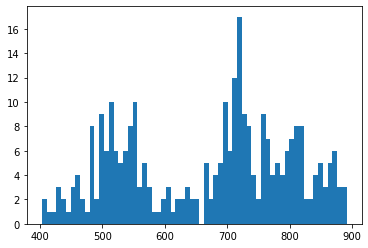

In [22]:
plt.hist(Is[(-Ih)>50].ravel(),64)
plt.show()

## 3D processing

In [23]:
I = np.transpose(image,(1,0,2))
hpx = I.shape
hpx = (np.array(hpx)/2).astype('int')
hpx

array([120, 120,  77])

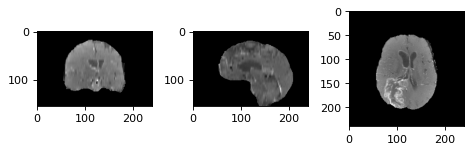

In [24]:
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(I[hpx[0],:,:]),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(I[:,hpx[1],:]),cmap='gray')
plt.subplot(133)
plt.imshow(I[:,:,hpx[2]],cmap='gray')
plt.tight_layout()
plt.show()

In [25]:
box3d = np.ones((5,5,5))*(1/(5*5*5))
print(box3d.shape)
Is = nd.convolve(I,box3d)
Is.shape

(5, 5, 5)


(240, 240, 155)

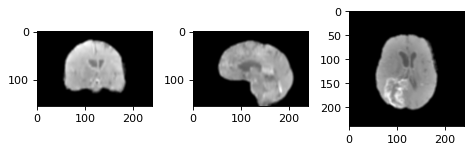

In [26]:
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(Is[hpx[0],:,:]),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(Is[:,hpx[1],:]),cmap='gray')
plt.subplot(133)
plt.imshow(Is[:,:,hpx[2]],cmap='gray')
plt.tight_layout()
plt.show()

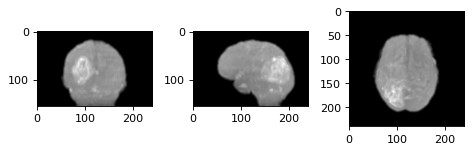

In [27]:
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(np.amax(Is,axis=0)),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(np.amax(Is,axis=1)),cmap='gray')
plt.subplot(133)
plt.imshow(np.amax(Is,axis=2),cmap='gray')
plt.tight_layout()
plt.show()

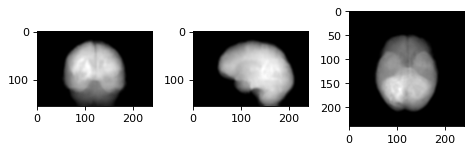

In [28]:
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(np.sum(Is,axis=0)),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(np.sum(Is,axis=1)),cmap='gray')
plt.subplot(133)
plt.imshow(np.sum(Is,axis=2),cmap='gray')
plt.tight_layout()
plt.show()

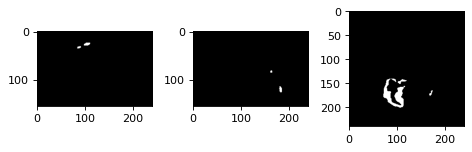

In [29]:
plt.figure(dpi=dpiv)
mask3d = np.zeros(Is.shape)
mask3d[nd.gaussian_filter(Is,1)>640] = 1
plt.subplot(131)
plt.imshow(np.rot90(mask3d[hpx[0],:,:]),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(mask3d[:,hpx[1],:]),cmap='gray')
plt.subplot(133)
plt.imshow(mask3d[:,:,hpx[2]],cmap='gray')
plt.tight_layout()
plt.show()

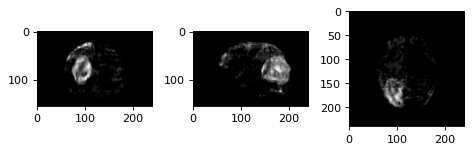

In [30]:
mask3d = np.zeros(I.shape)
mask3d[nd.gaussian_filter(I,1)>640] = 1
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(np.sum(mask3d,axis=0)),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(np.sum(mask3d,axis=1)),cmap='gray')
plt.subplot(133)
plt.imshow(np.sum(mask3d,axis=2),cmap='gray')
plt.tight_layout()
plt.show()

In [31]:
import scipy.ndimage.measurements as meas
from scipy import stats

In [32]:
l,num = meas.label(nd.binary_opening(mask3d,np.ones((3,3,3))))
print(num)

46


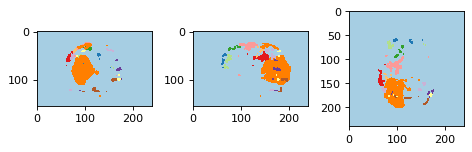

In [33]:
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(np.amax(l,axis=0)),cmap='Paired',interpolation='nearest')
plt.subplot(132)
plt.imshow(np.rot90(np.amax(l,axis=1)),cmap='Paired',interpolation='nearest')
plt.subplot(133)
plt.imshow(np.amax(l,axis=2),cmap='Paired',interpolation='nearest')
plt.tight_layout()
plt.show()

In [34]:
I_mode = stats.mode(l[l>0])
I_mode.mode

array([29], dtype=int32)

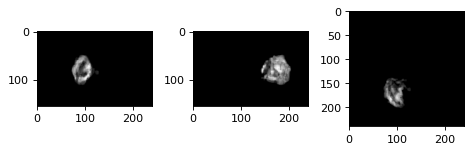

In [35]:
mask3d_new = (l == I_mode.mode)
plt.figure(dpi=dpiv)
plt.subplot(131)
plt.imshow(np.rot90(np.sum(mask3d_new,axis=0)),cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(np.sum(mask3d_new,axis=1)),cmap='gray')
plt.subplot(133)
plt.imshow(np.sum(mask3d_new,axis=2),cmap='gray')
plt.tight_layout()
plt.show()

### Extract features from Image and ROI (Region of Interest)
- area of ROI
- intensity mean of ROI
- intensity s.d. of ROI
- intensity median of ROI

In [36]:
num_enhanced = np.sum(mask3d_new>0)
print(data_dict['image_meta_dict']['pixdim'][:3])
volume_enhanced = np.prod(data_dict['image_meta_dict']['pixdim'][:3]) * num_enhanced
print(f'area: {volume_enhanced} mm^3')

[1. 1. 1.]
area: 41884.0 mm^3


In [37]:
roi_vals = I[mask3d_new>0]
roi_mean = np.mean(roi_vals)
roi_std = np.std(roi_vals)
roi_median = np.median(roi_vals)
print([roi_mean,roi_std,roi_median])

[755.4108, 108.117455, 735.0]
